# Quinta lista - Problema grupal 3

## Componentes del grupo

* Pol Casacuberta Gil
* Joaquin Faraone Prieto
* Agnès Felip i Díaz
* Marta Granero I Martí

## Sumemos de nuevo

## Los resultados del experimento de suma usando k-vecinos más cercanos fueron un poco decepcionantes incluso transformando los atributos para una mejor representación. Las relaciones no lineales entre algunos atributos fueron las culpables de estos resultados no óptimos. Ahora que conocemos otros clasificadores, podemos probar si pueden hacer un mejor trabajo.

## El escenario será el mismo, aprendiendo a sumar números de tres dígitos con ejemplos definidos por seis atributos, los tres primeros atributos corresponden a los tres dígitos del primer número y los tres últimos a los dígitos del segundo número. La salida tiene cuatro valores, uno para cada dígito para cada número del resultado de la suma. Por ejemplo:

|X1|X2|X3|X4|X5|X6|Y1|Y2|Y3|Y4|
|--|--|--|--|--|--|--|--|--|--|
|0 |1 |6 |4 |7 |7 |0 |4 |9 |3 |


### Procedemos a realizar los ejercicios que se nos piden

#### Incluimos las librerias necesarias

In [49]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import  ConfusionMatrixDisplay,classification_report,\
                             RocCurveDisplay, PrecisionRecallDisplay,\
                             accuracy_score, f1_score, precision_score, recall_score

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Binarizer
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC

from IPython.display import display, HTML #core.display deprecated
show_html = lambda html: display(HTML(html))

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve
from yellowbrick.classifier.rocauc import roc_auc

import random
import itertools
from itertools import permutations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Definimos los atributos que tendran los datasets

In [3]:
columns      = ["X1", "X2", "X3", "X4", "X5", "X6", "Y1", "Y2", "Y3", "Y4"]
data_columns = ["X1", "X2", "X3", "X4", "X5", "X6"]
y_columns    = ["Y1", "Y2", "Y3", "Y4"]

#### Creación de los datasets

In [7]:
#Function to create array
def prepareArray(number, size):
    X1 = list(map(int, str(number)))
    while len(X1) < size:
        X1.insert(0,0)
    return X1
    
def setFormat(first,second):
    total = first+second
    X1 = prepareArray(first,3)
    X2 = prepareArray(second,3)
    Y  =  prepareArray(total,4)
    return X1+X2+Y

def createDataset(n, seed=42):
    np.random.seed(seed)
    firsts = np.random.randint(0, 999, size=n)
    seconds= np.random.randint(0, 999, size=n)
    matrix = []
    
    for first, second in zip(firsts,seconds):
        matrix.append(setFormat(first,second))

    data = pd.DataFrame(matrix, columns=columns)
    data = data.drop_duplicates()
    
    return data

def createDataset_p(n, seed=42):
    """
    This method makes absolutely sure that we create exactly n 
    examples for the dataset, so that the datasets are strictly greater than each other.
    """
    max_number = 999
    np.random.seed(seed)
    random.seed(seed)
    values = np.linspace(0, max_number, 1000, dtype=int)
    unique_permutations = set(permutations(values, 2))

    samples = random.sample([*unique_permutations], k=n)  # picks k number of numbers from 0 to n without replacement
    matrix = []
    for sample in samples:
        matrix.append(setFormat(sample[0], sample[1]))
    data = pd.DataFrame(matrix, columns=columns)
    data = data.drop_duplicates()
    return data

### a)  Dado que vamos a utilizar clasificadores más potentes, probablemente necesitemos menos ejemplos para funcionar mejor, así que generad dos conjuntos de datos de 25.000 y 50.000 ejemplos. Dividid los conjuntos de datos en un conjunto de test y entrenamiento con una proporción de 90 %/10 %

#### Generamos los dos conjuntos de datos de 25.000 i 50.000 ejemplos

In [11]:
dataset0 = 25000
dataset1 = 50000

dataset0 = pd.DataFrame(createDataset_p(dataset0))
dataset1 = pd.DataFrame(createDataset_p(dataset1))

#### Dividimos los conjuntos de datoes en un conjunto de entrenamineto y test con una proporción de 90%/10% respectivamente

In [12]:
X_train_0, X_test_0 = train_test_split(dataset0, test_size=0.1, random_state=42, shuffle=True)
X_train_1, X_test_1 = train_test_split(dataset1, test_size=0.1, random_state=42, shuffle=True)

y_train_0 = X_train_0[y_columns]
X_train_0 = X_train_0.drop(y_columns, axis=1)
y_test_0 = X_test_0[y_columns]
X_test_0 = X_test_0.drop(y_columns, axis=1)

y_train_1 = X_train_1[y_columns]
X_train_1 = X_train_1.drop(y_columns, axis=1)
y_test_1 = X_test_1[y_columns]
X_test_1 = X_test_1.drop(y_columns, axis=1)

### b) Como recordaréis, este es un problema de clasificación de salida múltiple, por lo que necesita usar el objeto $\texttt{MultiOutputClassifier}$ de scikit learn. Esto envolverá los clasificadores para que pueda realizar este tipo de clasificación.

### Usad $\texttt{SVC}$ para la clasificación con un kernel rbf con diferentes valores para $\texttt{C}$. Podéis usar diferentes potencias de 10 para ese parámetro para ver dónde está el mejor acierto para los datos de test en lugar de usar validación cruzada, os tardará mucho si la usáis. Aseguraos de usar el parámetro $\texttt{n\_jobs}$ de los objetos de clasificación de salida múltiple para que las cosas se hagan en paralelo.

#### Para el primer conjunto de datos (dataset0)

In [40]:
regularization_c = [10**i for i in range(7)]

resultados_dataset0 = [    
    (r_c, MultiOutputClassifier(SVC(C=r_c,kernel='rbf',random_state=42),n_jobs=-1).fit(X_train_0,y_train_0).score(X_test_0,y_test_0)) for r_c in regularization_c]

print(resultados_dataset0)

1
10
100
1000
10000
100000
1000000
[(1, 0.594), (10, 0.934), (100, 0.9584), (1000, 0.964), (10000, 0.9592), (100000, 0.9592), (1000000, 0.9592)]


In [41]:
list_of_values_0 = list(map(lambda x: x[1], resultados_dataset0))
list_of_values_0

[0.594, 0.934, 0.9584, 0.964, 0.9592, 0.9592, 0.9592]

#### Para el primer conjunto de datos (dataset1)

In [42]:
regularization_c = [10**i for i in range(7)]

resultados_dataset1 = [    
    (r_c, MultiOutputClassifier(SVC(C=r_c,kernel='rbf',random_state=42),n_jobs=-1).fit(X_train_1,y_train_1).score(X_test_1,y_test_1)) for r_c in regularization_c]

print(resultados_dataset1)

1
10
100
1000
10000
100000
1000000
[(1, 0.7878), (10, 0.966), (100, 0.9856), (1000, 0.989), (10000, 0.9836), (100000, 0.9836), (1000000, 0.9836)]


In [43]:
list_of_values_1 = list(map(lambda x: x[1], resultados_dataset1))
list_of_values_1

[0.7878, 0.966, 0.9856, 0.989, 0.9836, 0.9836, 0.9836]

#### Ploteamos los resultados obtenidos

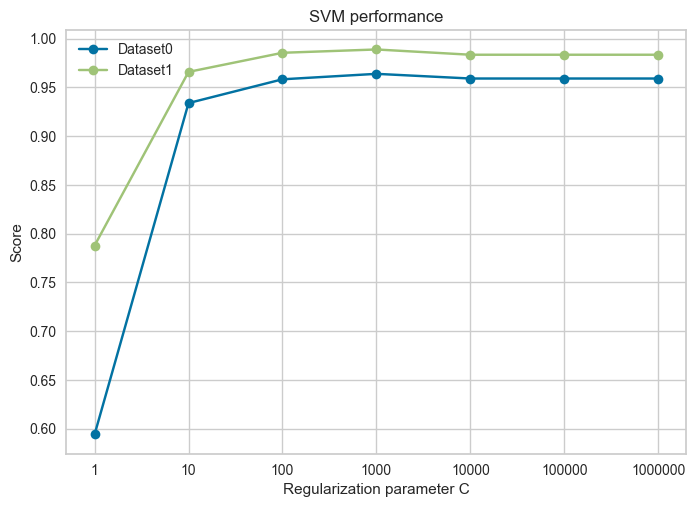

In [44]:
x_values = range(len(regularization_c))
x_label = "Regularization parameter C"
y_label = "Score"
title = "Evaluación del modelo SVM con un kernel rbf"
legend_labels = ['Dataset0', 'Dataset1']

plt.plot(list_of_values_0, marker="o")
plt.plot(list_of_values_1, marker="o")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.legend(legend_labels)
plt.xticks(x_values, regularization_c)
plt.show()

#### Mejores score del dataset0

In [45]:
def calculate_score(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    return classifier.score(X_test, y_test)

In [46]:
r_c = 1000
classifier = MultiOutputClassifier(SVC(C=r_c,kernel='rbf',random_state=42),n_jobs=-1)
score = calculate_score(classifier, X_train_0, y_train_0, X_test_0, y_test_0)
score

0.964

#### Mejores score del dataset1

In [68]:
r_c = 1000
classifier = MultiOutputClassifier(SVC(C=r_c,kernel='rbf',random_state=42),n_jobs=-1)
score = calculate_score(classifier, X_train_1, y_train_1, X_test_1, y_test_1)
score

0.989

### c) Usad $\texttt{GradientBoostingClassifier}$ con diferentes valores para el número de estimadores y la profundidad máxima de los árboles. La cantidad de estimadores no tiene que ser muy grande, pero probablemente necesitaréis alrededor de 50 árboles con la tasa de aprendizaje predeterminada. Además, los árboles demasiado poco profundos darán malos resultados. Evaluad el acierto sobre el test como en el apartado anterior.

### Podéis acceder a los clasificadores individuales del clasificador de salida múltiple con el atributo $\texttt{estimator\_}$. Obtened la importancia de los atributos para cada clasificador que encontraréis en el atributo $\texttt{feature\_importances}$ e interpretad los resultados.

#### Para el dataset0

In [71]:
estimators = [5, 10, 20, 30, 50, 70, 90, 100]
max_depths = [None, 1, 2, 3, 5, 8, 10, 15, 20]

resultados = [
    (estimator, 
     [MultiOutputClassifier(GradientBoostingClassifier(n_estimators=estimator, max_depth=m_d),
                            n_jobs=-1).fit(X_train_0, y_train_0).score(X_test_0, y_test_0) for m_d in max_depths])
    for estimator in estimators
]
print(resultados)

KeyboardInterrupt: 

In [ ]:
list_of_values_gb = list(map(lambda x: x[1], resultados))
list_of_values_gb

#### Ploteamos los resultados para el dataset0

In [ ]:
xvalues = np.arange(1, len(max_depths) + 1)
max_depths = [str(m_d) for m_d in max_depths]
names_estimators = [f"{estimator} estimators" for estimator in estimators]

plt.title("dataset0 GBC", fontsize=18, pad=20)
plt.xticks(xvalues, max_depths)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylabel("model score")
plt.xlabel("max tree depth")

for i, val in enumerate(estimators):
    plt.plot(xvalues, list_of_values_gb[i])

plt.legend(names_estimators)
plt.grid()
plt.show()

#### Mejores parámetros para el GBC modelo

In [ ]:
multi = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=50,max_depth=10),n_jobs=1);
multi.fit(X_train_0,y_train_0);
multi.estimators_

#### Para el dataset1

In [ ]:
estimators = [5, 10, 20, 30, 50, 70, 90, 100]
max_depths = [None, 1, 2, 3, 5, 8, 10, 15, 20]

resultados = [
    (estimator, 
     [MultiOutputClassifier(GradientBoostingClassifier(n_estimators=estimator, max_depth=m_d),
                            n_jobs=-1).fit(X_train_1, y_train_1).score(X_test_1, y_test_1) for m_d in max_depths])
    for estimator in estimators
]
print(resultados)

In [ ]:
list_of_values_gb = list(map(lambda x: x[1], resultados))
list_of_values_gb

#### Ploteamos los resultados para el dataset1

In [ ]:
xvalues = np.arange(1, len(max_depths) + 1)
max_depths = [str(m_d) for m_d in max_depths]
names_estimators = [f"{estimator} estimators" for estimator in estimators]

plt.title("dataset0 GBC", fontsize=18, pad=20)
plt.xticks(xvalues, max_depths)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.ylabel("model score")
plt.xlabel("max tree depth")

for i, val in enumerate(estimators):
    plt.plot(xvalues, list_of_values_gb[i])

plt.legend(names_estimators)
plt.grid()
plt.show()

#### Using the best parameters for the GBC model

In [ ]:
multi = MultiOutputClassifier(GradientBoostingClassifier(n_estimators=50,max_depth=10),n_jobs=-1);
multi.fit(X_train_1,y_train_1);
multi.estimators_

### d) ¿Por qué creéis que los resultados de estos clasificadores son mejores que los del clasificador k vecinos más cercanos? ¿Por qué creéis que necesitamos menos ejemplos para estos resultados?